In [9]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
DATASET_DIR = "./dataset"



In [11]:
os.listdir(DATASET_DIR)


['covid', 'normal']

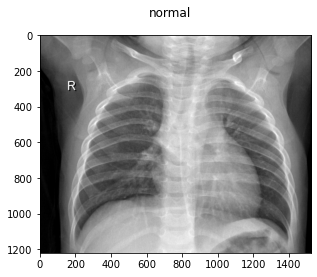

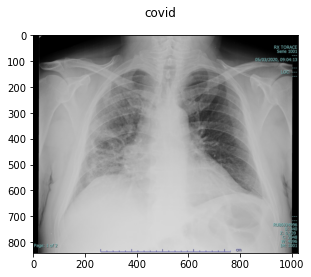

In [12]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

normal_images = []
for img_path in glob.glob(DATASET_DIR + '/normal/*'):
    normal_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('normal')
plt.imshow(normal_images[0], cmap='gray') 

covid_images = []
for img_path in glob.glob(DATASET_DIR + '/covid/*'):
    covid_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('covid')
plt.imshow(covid_images[0], cmap='gray') 

In [13]:
print(len(normal_images))
print(len(covid_images))

28
70


In [14]:
IMG_W = 150
IMG_H = 150
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 48
BATCH_SIZE = 6

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    DATASET_DIR, 
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle= False,
    subset='validation')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS)

Found 69 images belonging to 2 classes.
Found 29 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/48
11/11 [==============================] - 40s 4s/step - loss: 0.7813 - accuracy: 0.6970 - val_loss: 0.5817 - val_accuracy: 0.8750
Epoch 2/48
11/11 [==============================] - 6s 572ms/step - loss: 0.7266 - accuracy: 0.6984 - val_loss: 0.6065 - val_accuracy: 0.8750
Epoch 3/48
11/11 [==============================] - 6s 577ms/step - loss: 0.6778 - accuracy: 0.6825 - val_loss: 0.5748 - val_accuracy: 0.8750
Epoch 4/48
11/11 [==============================] - 6s 557ms/step - loss: 0.6593 - accuracy: 0.6984 - val_loss: 0.5500 - val_accuracy: 0.8750
Epoch 5/48
11/11 [==============================] - 6s 576ms/step - loss: 0.6116 - accuracy: 0.7143 - val_loss: 0.4745 - val_accuracy: 0.8750
Epoch 6/48
11/11 [==============================] - 7s 592ms/step - loss: 0.5985 - accuracy: 0.7302 - val_loss: 0.3754 - val_accuracy: 0

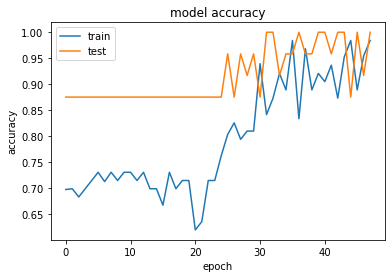

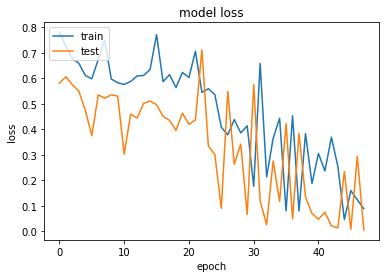

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9841269850730896
validation_accuracy 1.0


In [21]:
label = validation_generator.classes

In [22]:
pred= model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
{'covid': 0, 'normal': 1}
['covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid']


In [23]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(predicted_class_indices,label)
cf

array([[21,  8],
       [ 0,  0]], dtype=int64)

In [24]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted,0,All
Actual,,
0,21,21
1,8,8
All,29,29


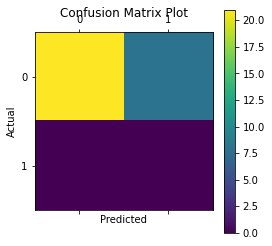

In [25]:
plt.matshow(cf)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();